##NUOVO TASK CLASSIFICAZIONE
Il nuovo task di classificazione ha come obiettivo la corretta classificazione di 5 classi di immagini prese dal dataset CIFAR-100. Per estrarre le feature è stata utilizzata una rete convoluzionale pre-trained VGG-16. Le feature estratte sono passate poi ad un classificatore classico (SVM in questo caso). Quest'ultimo ha il compito di classificare le varie feature estratte nella label giusta.

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

##DATASET
Il dataset utilizzato è stato preso tra i dataset resi disponibili su keras.datasets. Si tratta del dataset Cifar 100, composto da 60000 immagini, distribuite in 100 classi e 20 superclassi. E' stato realizzato dall'Università di Toronto. Le immagini provengono da diversi domini, mondo animale, mondo vegetale, persone, veicoli ecc...\
Per questo task sono state selezionate solo le ultime 5 classi presenti, in modo da diminuire il dataset, così da velocizzare le performance di training.

Le classi selezionate sono:\
95 => Whale = Balena \
96 => Oak = Quercia \
97 => Wolf = Lupo \
98 => Woman = Donna \
99 => Snake = Serpente \

Le immagini hanno dimensione 32x32x3.

Ogni classe è composta da 500 immagini di training e 100 immagini di test.

Il training set è composto da 2500 immagini, mentre il test set da 500 immagini.

Le immagini sono state pre-processate utilizzando la funzione preprocess_input di vgg16

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

train_indices = np.where(y_train.ravel() >= 95)
test_indices = np.where(y_test.ravel() >= 95)

x_train = x_train[train_indices]
y_train = y_train[train_indices]

x_test = x_test[test_indices]
y_test = y_test[test_indices]

169009152/169001437 [==============================] - 2s 0us/step


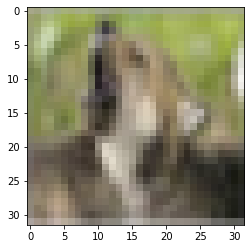

[97]


In [ ]:
from matplotlib import pyplot as plt
plt.imshow(x_train[1], interpolation='nearest')
plt.show()
print(y_train[1])

In [ ]:
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

2500 train samples
500 test samples


Si è utilizzata la rete VGG16 pre trained, escludendo i layer finali. I pesi per la rete già addestrata sono basati sul task "imagenet".

La rete in input accetta immagini di dimensione 32x32x3.\
La rete è composta da 5 blocchi, ogni blocco formato da 2/3 layer convoluzionali seguiti da un layer di max pooling.\
La dimensione dei filtri utilizzati raddoppia ad ogni blocco (64 al primo, 128 al secondo e così via)


In [ ]:
input_shape = x_train[0].shape
vgg16_model = VGG16(input_shape=input_shape, weights='imagenet', include_top=False)
vgg16_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
______________________________________________________________

##MODELLI

Il primo modello addestrato è composto dall'intera rete VGG16 e un strato flatten in modo appiattiere i dati da passare al classificatore SVM.

In [ ]:
base_model = keras.Sequential()
base_model.add(vgg16_model)
base_model.add(keras.layers.Flatten())
base_model.compile('Adam', 'categorical_crossentropy')
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


Il secondo modello addestrato è composto solo dalla parte iniziale della rete VGG16, infatti la rete è stata tagliata al 2° layer di pooling. Infine vi è ancora un strato flatten in modo appiattiere i dati da passare al classificatore SVM. 

In [ ]:
model2 = keras.Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer('block2_pool').output)

first_cut_model = keras.Sequential()
first_cut_model.add(model2)
first_cut_model.add(keras.layers.Flatten())
first_cut_model.compile('Adam', 'categorical_crossentropy')
first_cut_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 8, 8, 128)         260160    
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
Total params: 260,160
Trainable params: 260,160
Non-trainable params: 0
_________________________________________________________________


Il terzo modello addestrato è composto dalla metà iniziale della rete VGG16 fino al 3° layer di pooling. Infine vi è un strato flatten in modo appiattiere i dati da passare al classificatore SVM.

In [ ]:
model3 = keras.Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer('block3_pool').output)

second_cut_model = keras.Sequential()
second_cut_model.add(model3)
second_cut_model.add(keras.layers.Flatten())
second_cut_model.compile('Adam', 'categorical_crossentropy')
second_cut_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 4, 4, 256)         1735488   
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
Total params: 1,735,488
Trainable params: 1,735,488
Non-trainable params: 0
_________________________________________________________________


Il quarto e ultimo modello addestrato è composto dalla quasi totalità della rete VGG16 fino al 4 layer di pooling (taglio vicino al output). Infine vi è un strato flatten in modo appiattiere i dati da passare al classificatore SVM.

In [ ]:
model4 = keras.Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer('block4_pool').output)

third_cut_model = keras.Sequential()
third_cut_model.add(model4)
third_cut_model.add(keras.layers.Flatten())
third_cut_model.compile('Adam', 'categorical_crossentropy')
third_cut_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Functional)         (None, 2, 2, 512)         7635264   
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
Total params: 7,635,264
Trainable params: 7,635,264
Non-trainable params: 0
_________________________________________________________________


Si può vedere come il numero di parametri utilizzati cresce esponenzialmente  verso gli ultimi blocchi. Questo dipende dall'aumento del numero di filtri usati nei layer convoluzionali nei vari blocchi\
\
L'idea generale della feature extraction, utilizzando una rete pre-trained, è quello di tagliare vicino al output layer quando il nuovo task di classificazione è simile al task per cui è stata addestrata la rete utilizzata.
Al contrario se il nuovo task è differente conviene tagliare la rete nei primi layer, in quanto sono più generici.

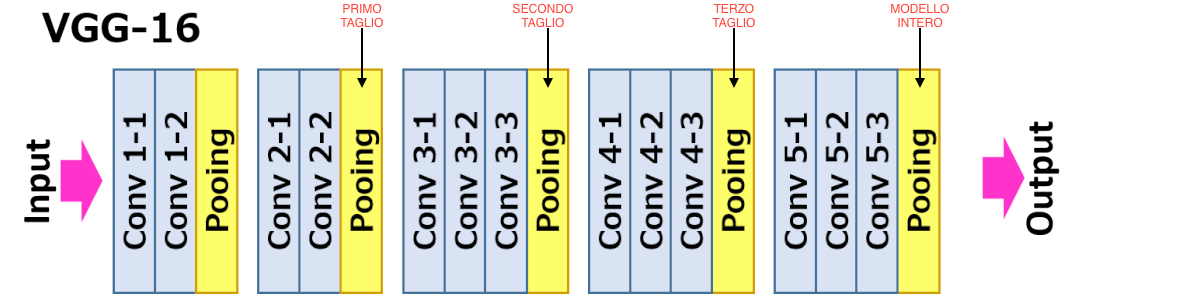

##TRAINING

E' stata definita una funzione trainSVM per splittare il training set in due: 
Training set e Validation set. Lo split utilizzato è 0.75. 

Le feature da passare in input al classificatore SVM sono state prima normalizzate. 

Gli hyper-parameter utilizzati per il classificatore SVM sono:
- Kernel = Lineare
- Penalty = L2
- Loss = Squared hinge
- C = 1
- Max iter = 2000

Una volta addestrato il classificatore SVM sono state calcolate le performance su training set, su validation set e su test set.

In [ ]:
def trainSVM(x_train, y_train, x_test, y_test):
  split = 0.75
  splitat = int(len(x_train) * split)

  x_train_features = x_train[:splitat]
  y_train_features = y_train[:splitat]

  x_val_features = x_train[splitat:]
  y_val_features = y_train[splitat:]

  y_train_features = np.argmax(y_train_features, axis=1)
  y_val_features = np.argmax(y_val_features, axis=1)
  y_test = np.argmax(y_test, axis=1)

  mean = np.mean(x_train_features)
  std = np.std(x_train_features)

  x_train_features = (x_train_features - mean) / std
  x_val_features = (x_val_features - mean) / std
  x_test = (x_test - mean) / std

  svm = LinearSVC(C = 1, max_iter=2000, loss='squared_hinge')
  svm.fit(x_train_features, y_train_features)

  train_predictions = svm.predict(x_train_features)
  print("Train accuracy", classification_report(y_train_features, train_predictions))

  val_predictions = svm.predict(x_val_features)
  print("Validation accuracy", classification_report(y_val_features, val_predictions))

  test_predictions = svm.predict(x_test)
  print("Test accuracy", classification_report(y_test, test_predictions))

###MODELLO INTERO

In [ ]:
train_features = base_model.predict(x_train)
test_features = base_model.predict(x_test)

In [ ]:
trainSVM(train_features, y_train, test_features, y_test)

Train accuracy               precision    recall  f1-score   support

          95       1.00      1.00      1.00       376
          96       1.00      1.00      1.00       366
          97       1.00      1.00      1.00       371
          98       1.00      1.00      1.00       376
          99       1.00      1.00      1.00       386

    accuracy                           1.00      1875
   macro avg       1.00      1.00      1.00      1875
weighted avg       1.00      1.00      1.00      1875

Validation accuracy               precision    recall  f1-score   support

          95       0.91      0.90      0.91       124
          96       0.95      0.89      0.92       134
          97       0.80      0.83      0.81       129
          98       0.84      0.81      0.83       124
          99       0.83      0.89      0.86       114

    accuracy                           0.87       625
   macro avg       0.87      0.87      0.87       625
weighted avg       0.87      0.87      0.8

###PRIMO TAGLIO

In [ ]:
train_features = first_cut_model.predict(x_train)
test_features = first_cut_model.predict(x_test)

In [ ]:
trainSVM(train_features, y_train, test_features, y_test)

Train accuracy               precision    recall  f1-score   support

          95       1.00      1.00      1.00       376
          96       1.00      1.00      1.00       366
          97       1.00      1.00      1.00       371
          98       1.00      1.00      1.00       376
          99       1.00      1.00      1.00       386

    accuracy                           1.00      1875
   macro avg       1.00      1.00      1.00      1875
weighted avg       1.00      1.00      1.00      1875

Validation accuracy               precision    recall  f1-score   support

          95       0.90      0.89      0.89       124
          96       0.97      0.97      0.97       134
          97       0.82      0.88      0.85       129
          98       0.82      0.78      0.80       124
          99       0.82      0.82      0.82       114

    accuracy                           0.87       625
   macro avg       0.87      0.87      0.87       625
weighted avg       0.87      0.87      0.8

###SECONDO TAGLIO

In [ ]:
train_features = second_cut_model.predict(x_train)
test_features = second_cut_model.predict(x_test)

In [ ]:
trainSVM(train_features, y_train, test_features, y_test)

Train accuracy               precision    recall  f1-score   support

          95       1.00      1.00      1.00       376
          96       1.00      1.00      1.00       366
          97       1.00      1.00      1.00       371
          98       1.00      1.00      1.00       376
          99       1.00      1.00      1.00       386

    accuracy                           1.00      1875
   macro avg       1.00      1.00      1.00      1875
weighted avg       1.00      1.00      1.00      1875

Validation accuracy               precision    recall  f1-score   support

          95       0.95      0.97      0.96       124
          96       1.00      0.96      0.98       134
          97       0.87      0.91      0.89       129
          98       0.93      0.88      0.90       124
          99       0.93      0.97      0.95       114

    accuracy                           0.94       625
   macro avg       0.94      0.94      0.94       625
weighted avg       0.94      0.94      0.9

###TERZO TAGLIO

In [ ]:
train_features = third_cut_model.predict(x_train)
test_features = third_cut_model.predict(x_test)

In [ ]:
trainSVM(train_features, y_train, test_features, y_test)

Train accuracy               precision    recall  f1-score   support

          95       1.00      1.00      1.00       376
          96       1.00      1.00      1.00       366
          97       1.00      1.00      1.00       371
          98       1.00      1.00      1.00       376
          99       1.00      1.00      1.00       386

    accuracy                           1.00      1875
   macro avg       1.00      1.00      1.00      1875
weighted avg       1.00      1.00      1.00      1875

Validation accuracy               precision    recall  f1-score   support

          95       0.95      0.97      0.96       124
          96       1.00      0.96      0.98       134
          97       0.88      0.92      0.90       129
          98       0.93      0.85      0.89       124
          99       0.91      0.96      0.94       114

    accuracy                           0.93       625
   macro avg       0.93      0.93      0.93       625
weighted avg       0.93      0.93      0.9

##PERFORMANCE ACCURACY

| | Training Accuracy | Validation Accuracy  | Test Accuracy |
| --- | --- | --- | --- |
| First Cutted Model  | 1.0 | 0.868 | 0.858 |
| Second Cutted Model | 1.0 | 0.936 | 0.924 |
| Third Cutted Model  | 1.0 | 0.932 | 0.926 |
| Entire Model        | 1.0 | 0.865 | 0.850 |

E' possibile notare come le performance maggiori si ottengono nel modello secondo cutted e third cutted, cioè modelli in cui la rete vgg-16 è stata tagliata molto vicino all'output layer. Mentre il modello in cui è stato eseguito nei primi layer risulta meno accurato. Così come nel caso del modello formato dall'intera rete vgg-16, che ha le performance peggiori tra tutti i modelli presi in esame.

Questo è riconducibile al fatto che il dataset del nuovo task è molto simile al dataset su cui è stata addestrata la rete VGG-16. Come detto in precedenza per task simili si preferisce tagliare la rete feature extraction verso i layer più vicini all'output.